In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lmfit.models import GaussianModel,ConstantModel

In [5]:
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/models/spec_lib/'
v_heii=np.genfromtxt(savdic+'v_axis_heii.txt')
v_ly=np.genfromtxt(savdic+'v_axis_ly.txt')

spec_lib_ly1=np.genfromtxt(savdic+'speclib_ly1.txt')
spec_lib_ly2=np.genfromtxt(savdic+'speclib_ly2.txt')
spec_lib_heii=np.genfromtxt(savdic+'speclib_heii.txt')
r_ly=np.genfromtxt(savdic+'r_ly.txt')
r_ly2=np.genfromtxt(savdic+'r_ly2.txt')
snr_ly2=np.genfromtxt(savdic+'snr_ly2.txt')

example for plot spectrum and fit it

In [6]:
class fittor:

    def __init__(self, speclib, lamda):
        self.speclib = speclib
        self.lamda = lamda

    
    def gaussian_fit(self, x, y, method):
        g1model = GaussianModel(prefix='g1_')
        g2model = GaussianModel(prefix='g2_')
        g3model = GaussianModel(prefix='g3_')
        cmodel = ConstantModel()

        paras = g1model.guess(data=y, x=x)
        paras.update(g2model.make_params())
        paras.update(g3model.make_params())
        
        amp_max=y.max()*200*np.sqrt(2*np.pi)
        paras['g1_amplitude'].set(min=0.)
        paras['g2_amplitude'].set(min=0.)
        paras['g3_amplitude'].set(min=0.)
        
        paras['g1_center'].set(min=-500.,max=500.)
        paras['g2_center'].set(min=-500.,max=500.)
        paras['g3_center'].set(min=500.,max=800.)
        
        paras['g1_sigma'].set(min=100.,value=150., max=300.)
        paras['g2_sigma'].set(min=100.,value=150.,max=300.)
        paras['g3_sigma'].set(min=100.,value=150.,max=300.)
        paras.update(cmodel.make_params())

        model = g1model + g2model + g3model + cmodel

        result = model.fit(y, x=x, params=paras, mothod=method)

        yfit = result.best_fit
        y_para = result.best_values

        residual = np.abs(y - yfit).mean()

        return yfit, y_para,result,residual
    
    

    def lib_fit(self, method):
        fitlib = []
        paralib = []
        outlib=[]
        residuallib=[]
        for i in range(self.speclib.shape[0]):
            yfit, ypara, out, residual = self.gaussian_fit(self.lamda,self.speclib[i, :],method=method)
            fitlib.append(yfit)
            paralib.append(ypara)
            outlib.append(out)
            residuallib.append(residual)

        return np.array(fitlib),pd.DataFrame(paralib),np.array(residuallib),outlib
    
    def parameter_filter(self,snr,paralib,thre=20.):
        
        paralib_filtered=pd.DataFrame({})
        for i in range(snr.size):
            if snr[i]>=thre:
                paralib_filtered=paralib_filtered.append(paralib.loc[i])
                
        return paralib_filtered

### fit example

这里用的是[lmfit](https://lmfit.github.io/lmfit-py/)这个包做的拟合，采用两个高斯成分，比较tricky的地方是对于有些拟合算法来说，结果十分依赖于输入的初始拟合参数，[这里](https://lmfit.github.io/lmfit-py/fitting.html#choosing-different-fitting-methods)给出了可以用的拟合算法。需要做的是找到最好的初始参数或者不十分依赖于初始参数的算法。或者可以对每一个光谱人为选一组比较好的拟合参数。

In [4]:
ly_fittor= fittor(spec_lib_ly2, v_ly)
fitted_lib,paralib,residual_lib,outlib = ly_fittor.lib_fit(method='shgo')
paralib_filtered=ly_fittor.parameter_filter(snr_ly2,paralib)

/usr/local/lib/python3.7/site-packages/lmfit/model.py:969: UserWarning: The keyword argument mothod does not match any arguments of the model function. It will be ignored.
  "It will be ignored.", UserWarning)


In [7]:
def spec_plot(nx,ny,x,y_lib,outlib,fitted_lib,paralib,ylim,textcoor,delta=0,jud=False,snr=None,snr_thre=20.):
    spec_ly_lib_plot=spec_lib_ly2
    yerr_ly=1.14
    fig,ax=plt.subplots(nx,ny,sharex=True,sharey='row')
    ax=ax.flatten()

    for i in range(ax.size):
        
        ax[i].errorbar(x,y_lib[i+delta],yerr=yerr_ly*np.ones_like(y_lib[i+delta]),
                       capsize=3.,c='black')
        ax[i].scatter(x,y_lib[i+delta],c='black')
        ax[i].plot(x,fitted_lib[i+delta],c='orange',linewidth=5.)


        comp=outlib[i+delta].eval_components(x=x)
        ax[i].plot(x,comp['g1_'],c='blue',linestyle='dashed',linewidth=1.5)
        ax[i].plot(x,comp['g2_'],c='green',linestyle='dashed',linewidth=1.5)
        ax[i].plot(x,comp['g3_'],c='dimgray',linestyle='dashed',linewidth=1.5)
            

        ax[i].vlines(0,ylim[0],ylim[1],color='red',lw=5)
        ax[i].vlines(paralib['g1_center'][i+delta],ylim[0],
                     ylim[1],color='blue',linestyle='dashed')
        ax[i].vlines(paralib['g2_center'][i+delta],ylim[0],
                     ylim[1],color='green',linestyle='dashed')
        ax[i].vlines(paralib['g3_center'][i+delta],ylim[0],
                     ylim[1],color='dimgray',linestyle='dashed')

        ax[i].text(textcoor[0],textcoor[1],'window %d'%(i+delta),fontsize=15.)
        ax[i].tick_params(axis='both', which='both',top=True,right=True)
        ax[i].minorticks_on()
        ax[i].set_ylim(ylim[0],ylim[1])
        if snr[i+delta]>=snr_thre:
            ax[i].scatter(-textcoor[0],textcoor[1],marker='*',color='red',s=200)
        if jud:
            if i==13:
                fig.delaxes(ax[-1])
                break

    fig.text(0.08,0.6,r'F$_{\rm \lambda}$ [10$^{-19}$ erg s$^{-1}$ cm$^{-2}$ $\AA ^{-1}$]',
             rotation='vertical',fontsize=25)
    fig.text(0.5,0.05,r'V [km s$^{-1}$]',fontsize=25)
    plt.rcParams['figure.figsize'] = [20,15]
    plt.subplots_adjust(wspace=0.05,hspace=0.)

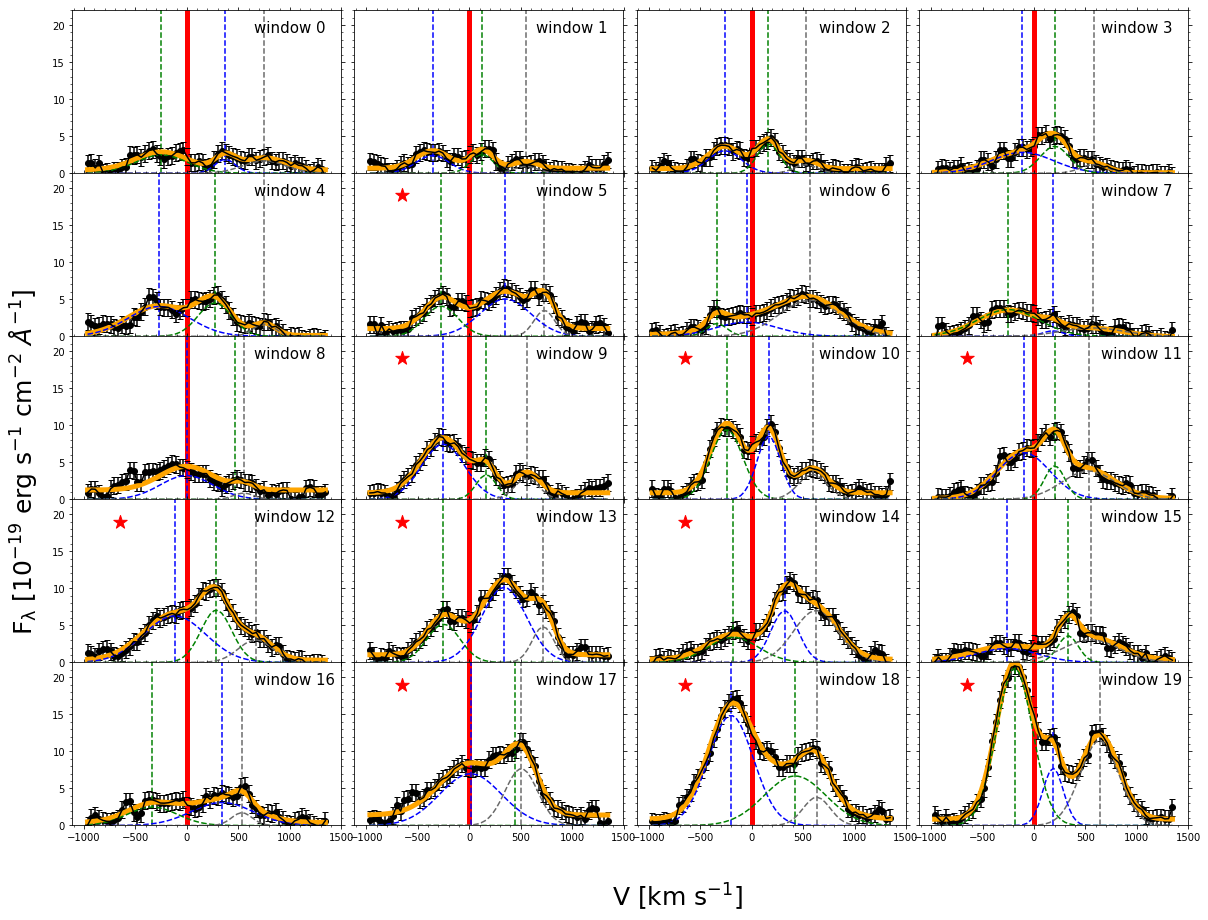

In [9]:
spec_plot(5,4,v_ly,spec_lib_ly2,outlib,fitted_lib,
          paralib=paralib,ylim=[0,22],textcoor=[650,19],snr=snr_ly2)
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/models/img/'
plt.show()
# plt.savefig(savdic+'fit_spec_ly1.png',dpi=300)

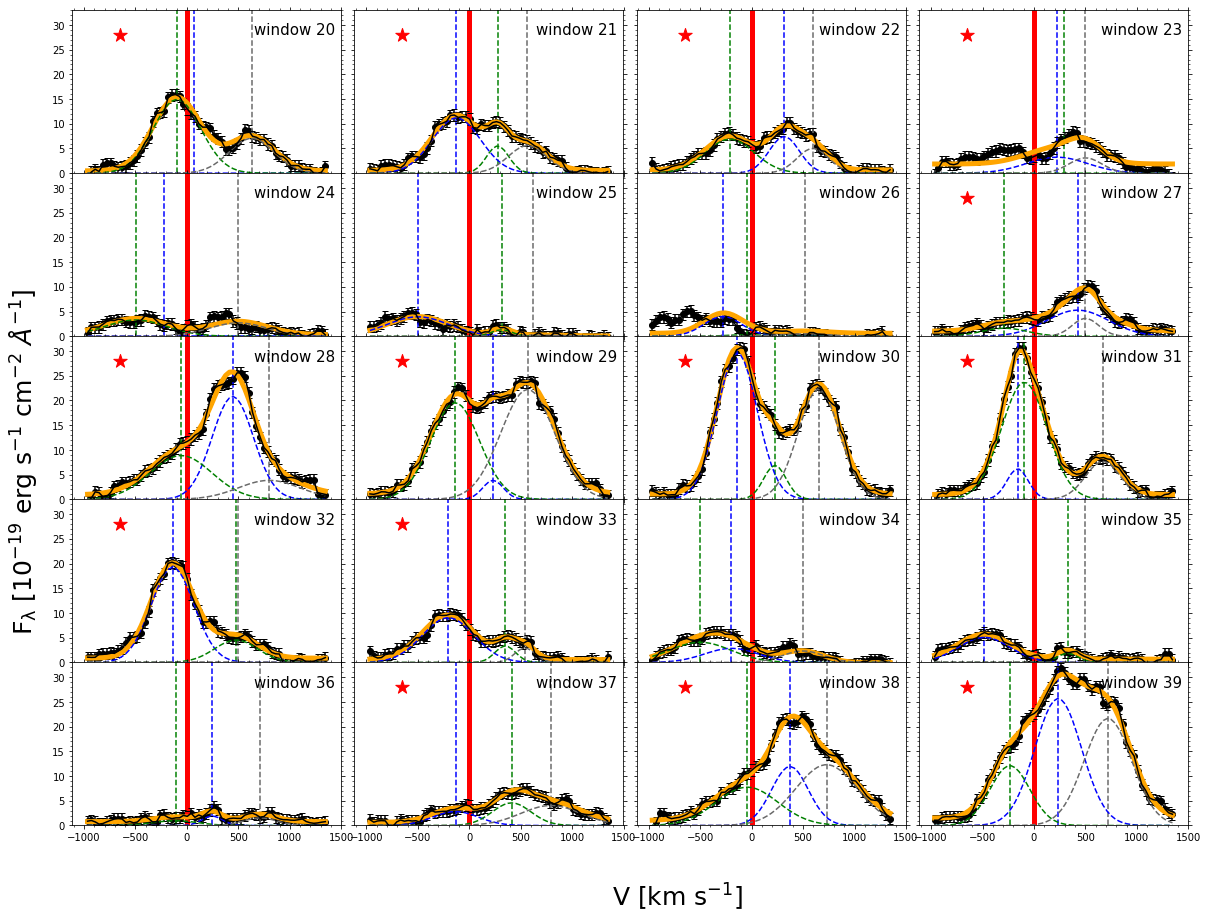

In [10]:
spec_plot(5,4,v_ly,spec_lib_ly2,outlib,fitted_lib,
          paralib=paralib,ylim=[0,33],textcoor=[650,28],delta=20,snr=snr_ly2)
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/models/img/'
plt.show()
# plt.savefig(savdic+'fit_spec_ly2.png',dpi=300)

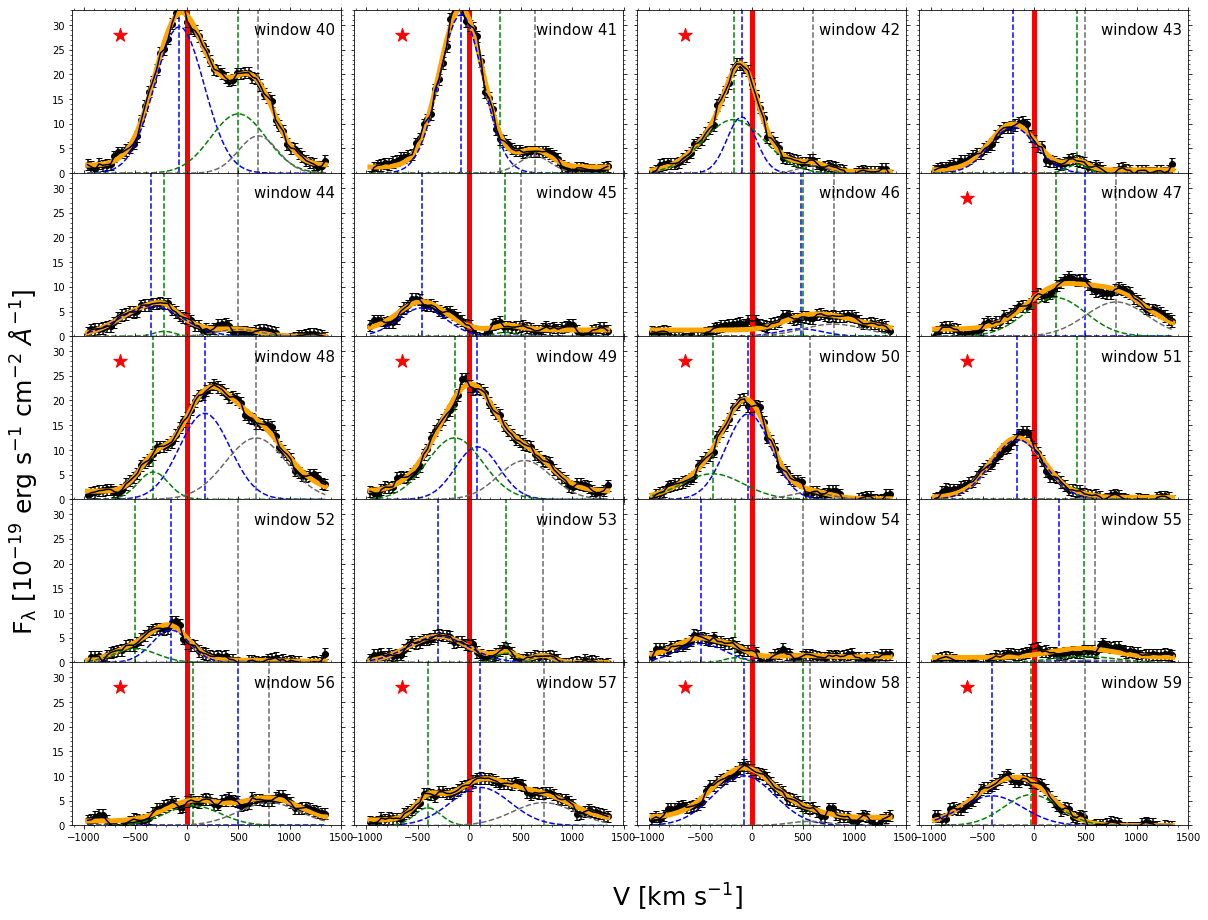

In [11]:
spec_plot(5,4,v_ly,spec_lib_ly2,outlib,fitted_lib,
          paralib=paralib,ylim=[0,33],textcoor=[650,28],delta=40,snr=snr_ly2)
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/models/img/'
plt.show()
# plt.savefig(savdic+'fit_spec_ly3.png',dpi=300)

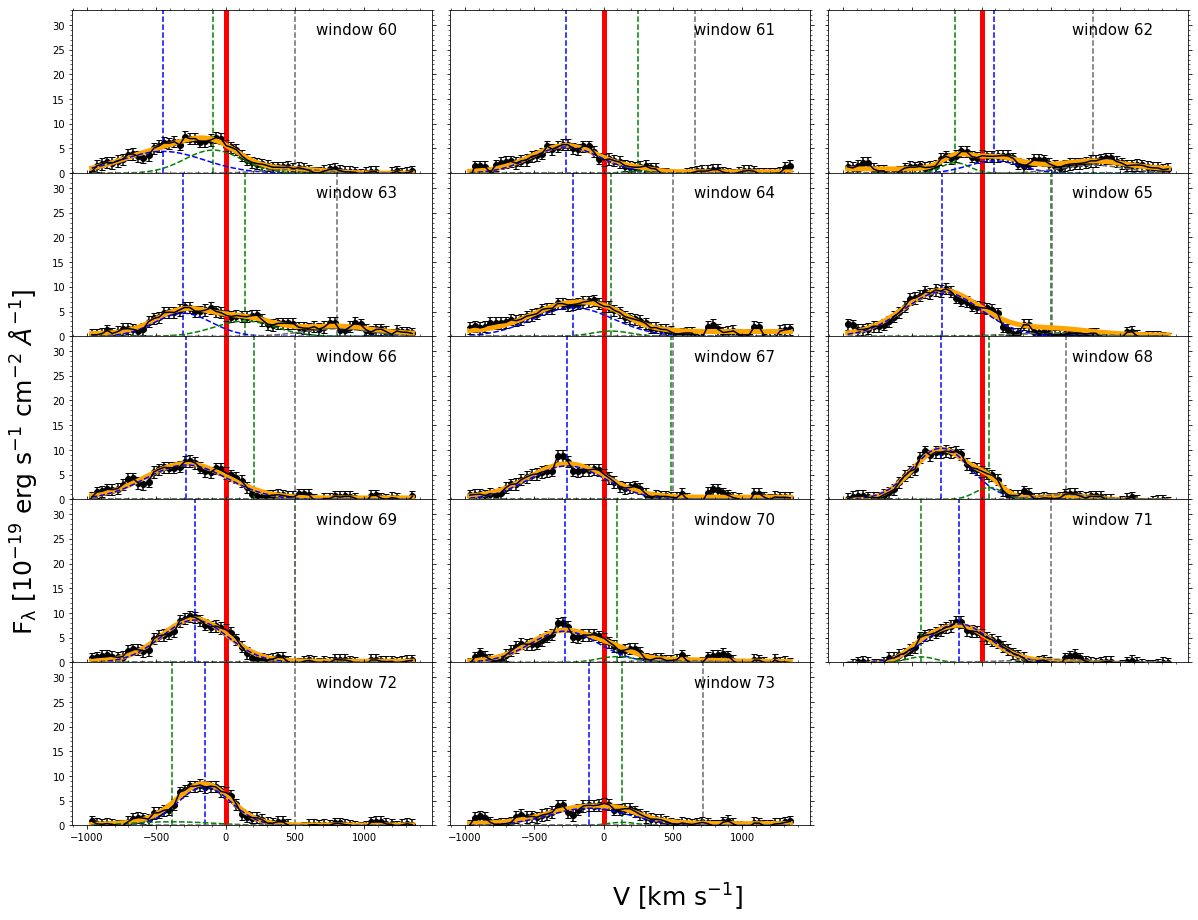

In [12]:
spec_plot(5,3,v_ly,spec_lib_ly2,outlib,fitted_lib,
          paralib=paralib,ylim=[0,33],textcoor=[650,28],delta=60,jud=True,snr=snr_ly2)
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/models/img/'
plt.show()
# plt.savefig(savdic+'fit_spec_ly4.png',dpi=300)

In [17]:
g1_v_err=np.array([outlib[i].params['g1_center'].stderr for i in range(len(outlib))]).astype(np.float64)
g1_v_err[g1_v_err>1000.]=np.nan
g2_v_err=np.array([outlib[i].params['g2_center'].stderr for i in range(len(outlib))]).astype(np.float64)
g2_v_err[g2_v_err>1000.]=np.nan
g3_v_err=np.array([outlib[i].params['g3_center'].stderr for i in range(len(outlib))]).astype(np.float64)
g3_v_err[g3_v_err>1000.]=np.nan

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


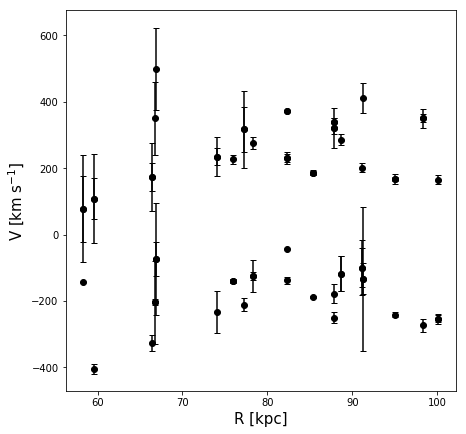

In [23]:
fig,ax=plt.subplots(1,1)
# index_filtered=paralib_filtered.index
index_filtered=np.array([5,9,10,11,12,13,14,19,21,22,29,30,33,37,38,39,40,48,49,57])
ax.errorbar(r_ly2[index_filtered],paralib_filtered['g1_center'][index_filtered],
            yerr=g1_v_err[index_filtered],fmt='o',color='black',capsize=3.)
ax.errorbar(r_ly2[index_filtered],paralib_filtered['g2_center'][index_filtered],
            yerr=g2_v_err[index_filtered],fmt='o',color='black',capsize=3.)
ax.errorbar(r_ly2[index_filtered],paralib_filtered['g1_center'][index_filtered],
            yerr=g3_v_err[index_filtered],fmt='o',color='black',capsize=3.)

ax.set_xlabel('R [kpc]',fontsize=15.)
ax.set_ylabel(r'V [km s$^{-1}$]',fontsize=15.)
plt.rcParams['figure.figsize'] = [7,7]
savdic='/Users/shiwuzhang/WS/ASTRO/MAMMOTH_KCWI/models/img/'
# plt.show()
plt.savefig(savdic+'fit_spec_velo_profile.png',dpi=300)